# Predicting COVID Deaths with PyTorch

In this project, I am using PyTorch to create a regression model that can predict how many deaths there will be for a WI census tract, given the number of people who have tested positive, broken down by age. The train.csv and test.csv files used for this task are based on this dataset: https://data.dhsgis.wi.gov/datasets/wi-dhs::covid-19-vaccination-data-by-census-tract

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

## Loading Data

In [2]:
# Load CSVs to Dataframe
test_df = pd.read_csv("data/test.csv")
train_df = pd.read_csv("data/train.csv")

In [3]:
# Create Numpy Arrays from Dataframe
trainX = train_df.values[:,:10]
trainY = train_df.values[:,10].reshape(-1,1)

testX = test_df.values[:,:10]
testY = test_df.values[:,10].reshape(-1,1)

In [4]:
# Convert Numpy Arrays to PyTorch
trainX = torch.from_numpy(trainX).to(torch.float64)
trainY = torch.from_numpy(trainY).to(torch.float64)

testX = torch.from_numpy(testX).to(torch.float64)
testY = torch.from_numpy(testY).to(torch.float64)

## Part 1: Prediction with Hardcoded Model

Let's predict the number of COVID deaths in the test dataset under the assumption that the deathrate is 0.004 for those <60 and 0.03 for those >=60

In [5]:
coef = torch.tensor([
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040], # POS_50_59_CP
        [0.0300], # POS_60_69_CP
        [0.0300],
        [0.0300],
        [0.0300]
], dtype=testX.dtype)
#coef

In [6]:
#coef.shape, testX.shape

### Check for GPU availability

In [7]:
if torch.cuda.is_available():
    trainX = trainX.to("cuda")
    trainY = trainY.to("cuda")
    
    testX = testX.to("cuda")
    testY = testY.to("cuda")
    
    coef = coef.to("cuda")
    print("Using GPU")
else:
    print("No GPU available.")
    print("Using CPU")

No GPU available.
Using CPU


#### Let's predict on the first instance of testX

In [8]:
#testX[[0], :].shape # torch.Size([1, 10])
#coef.shape          # torch.Size([10, 1])
predicted_death = testX[[0], :] @ coef

In [9]:
print(f"Predicted number of deaths in this tract using the Naive hardcoded model: {predicted_death.item()}")

Predicted number of deaths in this tract using the Naive hardcoded model: 9.844


## Part 2: R^2 Score

We will be calculating the R^2 score (https://en.wikipedia.org/wiki/Coefficient_of_determination) which is a measure of how much variance in the y column can be capptured by our model (with 1 being the best score). Since there exist multiple definitions of R^2 score, we will be defining it in terms of 2 variabels:

- **SStot**: to compute this, we first compute the average `testY` value. Then we subtract to get the difference between each `testY` value and the average. Lastly, we square the differences, and add the results to get `SStot`
- **SSreg**: this is the same as `SStot`, but instead of subtracting the average from each `testY` value, we subtract the prediction from `testY`

If our predictions are good, `SSreg` will be much smaller than `SStot`. So define `improvement = SStot - SSreg`.

The R^2 score is just `improvement/SStot`.

Now let us generalize the above logic into a reusable function r2_score(trueY, predictedY), that can compute the R^2 score given any vector of true values alongside a vector of predictions. 

In [10]:
def r2_score(trueY, predictedY):
    def calculate_SStot(trueY, avg_trueY):
        return torch.sum(torch.pow((trueY-avg_trueY), 2))
    
    def calculate_SSreg(trueY, predictedY):
        return torch.sum(torch.pow((trueY-predictedY), 2))
        
    
    # Defining Variables
    SStot, SSreg, improvement = None, None, None
    avg_trueY = testY.mean()
    
    # Calculate SStot, SSreg, Improvement, R^2 score
    SStot = calculate_SStot(avg_trueY = avg_trueY, 
                            trueY = testY)
    SSreg = calculate_SSreg(trueY = testY, 
                            predictedY = predictedY)
    
    #print(f"SStot: {SStot}")
    #print(f"SSreg: {SSreg}")
    
    improvement = SStot - SSreg
    #print(f"improvement: {improvement}")
    
    r2_score = improvement / SStot
    #print(f"R^2 Score: {r2_score}")
    
    return r2_score
    
    

Let us calculate the R^2 score of the predictions made by our hardcoded model

In [11]:
# These are the predictions made by our model
predictedY = testX @ coef 

# R^2 Score
r2_scr = r2_score(trueY = testY,
                  predictedY=predictedY)
print(f"R^2 Score: {r2_scr}")

R^2 Score: 0.41103503288417204


## Part 3: Optimization

Given `y = x^2 - 8x + 19`, we want to find the `x` value that minimizes y.<br>
We will use a PyTorch optimizer (SGD) to try to find a good `x` value. The optimizer will run a loop where it computes `y`, computes how a small change in `x` would effect `y`, then makes a small change to `x` to try to make `y` smaller.

##### Q. what is `y` when `x` is a tensor containing 0.0?

In [12]:
x = torch.tensor(0.0, requires_grad = True)
y = x**2 - 8*x + 19
y.item()

19.0

Okay now let us find the optimal `x`, given `y = x^2 - 8x + 19`

tensor(0.8000, requires_grad=True) tensor(19., grad_fn=<AddBackward0>)
tensor(1.4400, requires_grad=True) tensor(13.2400, grad_fn=<AddBackward0>)
tensor(1.9520, requires_grad=True) tensor(9.5536, grad_fn=<AddBackward0>)
tensor(2.3616, requires_grad=True) tensor(7.1943, grad_fn=<AddBackward0>)
tensor(2.6893, requires_grad=True) tensor(5.6844, grad_fn=<AddBackward0>)
tensor(2.9514, requires_grad=True) tensor(4.7180, grad_fn=<AddBackward0>)
tensor(3.1611, requires_grad=True) tensor(4.0995, grad_fn=<AddBackward0>)
tensor(3.3289, requires_grad=True) tensor(3.7037, grad_fn=<AddBackward0>)
tensor(3.4631, requires_grad=True) tensor(3.4504, grad_fn=<AddBackward0>)
tensor(3.5705, requires_grad=True) tensor(3.2882, grad_fn=<AddBackward0>)
tensor(3.6564, requires_grad=True) tensor(3.1845, grad_fn=<AddBackward0>)
tensor(3.7251, requires_grad=True) tensor(3.1181, grad_fn=<AddBackward0>)
tensor(3.7801, requires_grad=True) tensor(3.0756, grad_fn=<AddBackward0>)
tensor(3.8241, requires_grad=True) tenso

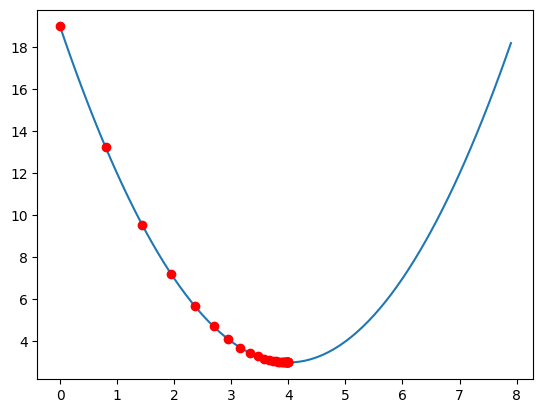

In [13]:
def f(x):
    return x**2 - 8*x + 19

x_values_range = torch.arange(0, 8, 0.1) # this is for the graph
y = f(x_values_range)
plt.plot(x_values_range, y)


x = torch.tensor(0.0, requires_grad = True) # this is the value 
                                            # we want to optimize
optimizer = torch.optim.SGD([x], lr=0.1)    # SGD optimizer instance

# Optimization begins below
for epoch in range(30):
        optimizer.zero_grad() # set x.grad = 0 before the next loop
        y = f(x)
        plt.plot(x.detach(), y.detach(), "ro")
        y.backward()
        # make a small change to x, based on the gradient
        # doesn't set gradient, but adds to x.grad
        optimizer.step() 
        print(x, y)

In [14]:
print(f"The optimized value of x is {x.item()}")

The optimized value of x is 3.9950480461120605


## Part 4: Linear Regression

In **Part 1** we used a hardcoded `coef` vector to predict COVID deaths. Now we will start with random coefficients and build a Linear CLassifier, and use an instance of `SGD` to optimize the coefficients

We will take the following steps in the following section:
- create a TensorDataset from `trainX` and `trainY`
- create a DataLoader that uses the Dataset created in the preceeding step (this will give us the added options of shuffling, and setting different batch sizes)
- create a simple linear model by initializing `torch.nn.Linear`
- create an optimizer from `torch.optim.SGD` that will optimize the `.weight` and `.bia`s parameters of the `model`
- we will train our model in many epochs, and use `torch.nn.MSELoss`
- Lastly we will report the R^2 score of the predictions of our model using the testData (Goal is to imporve the r^2 score from part 1, and achieve at least 50% accuracy)

In [15]:
torch.manual_seed(29)
# Create a dataset
dataset = torch.utils.data.TensorDataset(
    trainX,
    trainY
)

# create a DataLoader
dataloader = torch.utils.data.DataLoader(dataset, 
                                         shuffle=True, 
                                         batch_size=10)

In [16]:
torch.manual_seed(29)
# Create a model
din = trainX.shape[1] # number of inputs = 10
dout = trainY.shape[1] # number of outputs = 1
dth_prdctr_mdl = torch.nn.Linear(din, dout, dtype=torch.float64)

# Define an SGD optimizer instance for model
mdl_optimizer = torch.optim.SGD([dth_prdctr_mdl.weight, dth_prdctr_mdl.bias],
                                lr = 0.000001)

# Define a Mean Squared Error Loss function for model
loss_fnctn = torch.nn.MSELoss()

#### Now that we have initialized our data, and the model, let us start training the model

In [17]:
# metadata
torch.manual_seed(29)
epochs = 150
time_start, time_end = time.time(), None

# Training model
for epoch in range(epochs):
    for batchX, batchY in dataloader:
        predictedDeath = dth_prdctr_mdl(batchX)
        loss = loss_fnctn(batchY, predictedDeath)
        loss.backward()           # update weight.grad and bias.grad
        mdl_optimizer.step()      # update weight, bias based on gradient
        mdl_optimizer.zero_grad() # weight.grad = 0, bias.grad = 0
    
    x, y = dataset[:]  
    # print out the loss of our model after 
    # every 10 iterations of training
    if epoch%10 == 0:
        print(f"End of Epoch: {epoch}, Loss: {loss_fnctn(y, dth_prdctr_mdl(x))}") 
    
time_end = time.time()

End of Epoch: 0, Loss: 214.69547835211785
End of Epoch: 10, Loss: 39.93378324436931
End of Epoch: 20, Loss: 30.20665286741488
End of Epoch: 30, Loss: 30.401492074645816
End of Epoch: 40, Loss: 28.91677997134669
End of Epoch: 50, Loss: 36.7639428906243
End of Epoch: 60, Loss: 26.801339214844933
End of Epoch: 70, Loss: 27.29075570335084
End of Epoch: 80, Loss: 27.425750973293066
End of Epoch: 90, Loss: 32.23241061780809
End of Epoch: 100, Loss: 26.89347006650086
End of Epoch: 110, Loss: 26.644116892686863
End of Epoch: 120, Loss: 36.55399100743545
End of Epoch: 130, Loss: 100.796352678503
End of Epoch: 140, Loss: 26.543583721638896


#### Execution time for training model

In [18]:
print(f"Total time taken for training: {str(time_end - time_start)[:5]} seconds")

Total time taken for training: 5.333 seconds


#### Let us now calculate the R^2 Score of our model using the function we defined in **Part 2**. We will use `testX`, and `testY`

In [19]:
predictedDeath_byModel = dth_prdctr_mdl(testX)

r2_score_dth_prdctr_mdl = r2_score(trueY=testY,
                                   predictedY=predictedDeath_byModel)
print(f"R^2 Score: {r2_score_dth_prdctr_mdl}")

R^2 Score: 0.57652473942537


#### Let us visualize the weights of our model

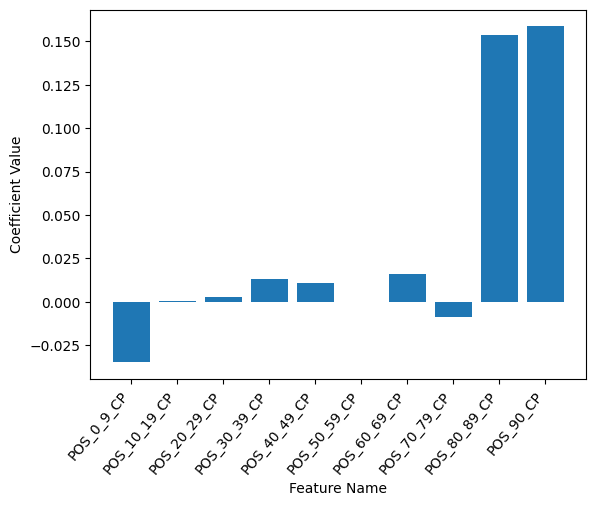

In [20]:
# Extract the weight tensor from the model 
# and convert it to a NumPy array
weights = dth_prdctr_mdl.weight.detach().numpy()
x_labels = list(test_df.columns)[:-1]

# Plot a bar graph of the weights
fig, ax = plt.subplots()
ax.bar(range(weights.shape[1]), weights[0])
ax.set_xticks(range(weights.shape[1])) # set the tick positions for every tick
ax.set_xticklabels([label for label in x_labels], rotation=50, ha="right")
ax.set_xlabel("Feature Name")
ax.set_ylabel("Coefficient Value")
plt.show()